### Multiclass Classification

This project aims to build a multiclass classification model. The dataset on [diamonds](https://www.kaggle.com/datasets/shivam2503/diamonds) comes from Kaggle. We'll use the model to predict diamond cut quality: Fair, Good, Very Good, Premium, Ideal. Other given attributes include:
- **price**: in US dollars
- **carat**: weight (g?)
- **color**: from J (worst) to D (best)
- **clarity**: how clear from I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, to IF (best)
- **depth**: total depth percentage = z / mean(x, y)
- **table**: width of diamond top relative to widest point
- **x**: length in mm
- **y**: width in mm
- **z**: depth in mm

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import importlib
import auxiliary as aux

In [2]:
df = pd.read_csv(Path('diamonds.csv')).drop("Unnamed: 0", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [3]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
# Prepare labels
y = df['cut'].values.flatten()
y

array(['Ideal', 'Premium', 'Good', ..., 'Very Good', 'Premium', 'Ideal'],
      dtype=object)

In [5]:
# Prepare features
X = df.drop('cut', axis=1)
X

,carat,color,clarity,depth,table,price,x,y,z
0,0.23,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...
53935,0.72,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [6]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print("Complete dataset:", X.shape)
print("Train dataset:", X_train.shape)
print("Test dataset:", X_test.shape)

Complete dataset: (53940, 9)
Train dataset: (43152, 9)
Test dataset: (10788, 9)


TODO: A couple categorical features can be ordinally encoded because they represent a scale. However, for simplicity let's one hot encode all categorical feature as a start.

In [7]:
# Build model pipeline
features = X.columns

cat_features = ['color', 'clarity']

num_features = [f for f in features if f not in cat_features]

ohe = ColumnTransformer([
      ('ohe_features', OneHotEncoder(), cat_features),
      ('scaled_num', StandardScaler(), num_features)
      ])

model = Pipeline([('ohe', ohe),
                  ('est', RandomForestClassifier(random_state=42))])

model.fit(X_train, y_train);

print(classification_report(y_test, model.predict(X_test)))
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

        Fair       0.91      0.87      0.89       335
        Good       0.76      0.67      0.72      1004
       Ideal       0.82      0.92      0.87      4292
     Premium       0.74      0.81      0.77      2775
   Very Good       0.66      0.47      0.55      2382

    accuracy                           0.77     10788
   macro avg       0.78      0.75      0.76     10788
weighted avg       0.76      0.77      0.76     10788

              precision    recall  f1-score   support

        Fair       1.00      1.00      1.00      1275
        Good       1.00      1.00      1.00      3902
       Ideal       1.00      1.00      1.00     17259
     Premium       1.00      1.00      1.00     11016
   Very Good       1.00      1.00      1.00      9700

    accuracy                           1.00     43152
   macro avg       1.00      1.00      1.00     43152
weighted avg       1.00      1.00      1.00     43152



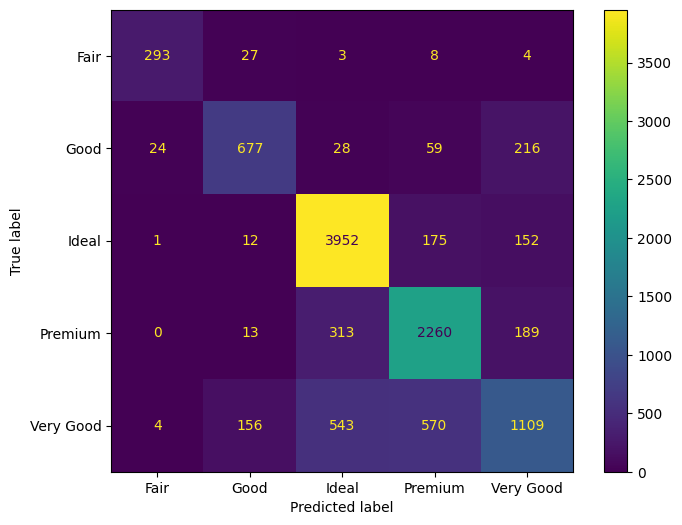

In [8]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, model.predict(X_test))
cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
cmp.plot(ax=ax)
plt.show();

Now that the model is working, let's wrap everything into functions to facilitate model iterations and maintenance. We want to be able to start from the raw csv (so that hypothetically newly recorded data in the future can be used), process it, extract features of interest, and run the classifier model in an automated workflow to minimize errors.

Results for test set:
              precision    recall  f1-score   support

        Fair       0.91      0.87      0.89       335
        Good       0.76      0.67      0.72      1004
       Ideal       0.82      0.92      0.87      4292
     Premium       0.74      0.81      0.77      2775
   Very Good       0.66      0.47      0.55      2382

    accuracy                           0.77     10788
   macro avg       0.78      0.75      0.76     10788
weighted avg       0.76      0.77      0.76     10788



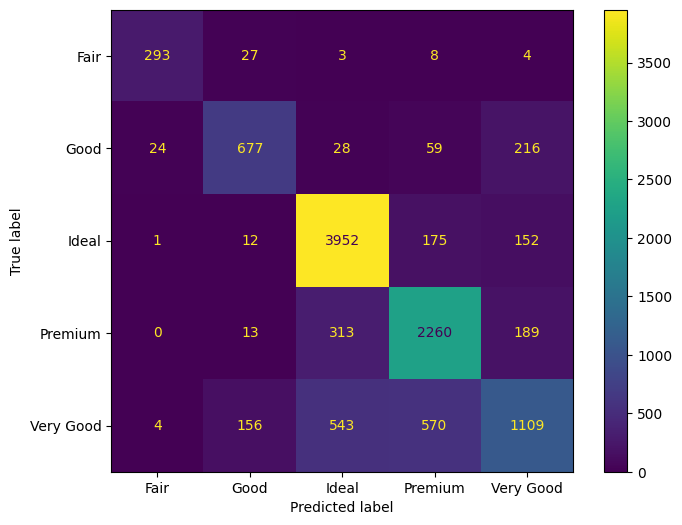

In [9]:
importlib.reload(aux) # Reload necessary for notebooks if import was updated
path = Path('diamonds.csv')
features = ['carat', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']
aux.run_model(path, features, RandomForestClassifier(random_state=42));

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Results for test set:
              precision    recall  f1-score   support

        Fair       0.90      0.85      0.88       335
        Good       0.76      0.67      0.71      1004
       Ideal       0.82      0.93      0.87      4292
     Premium       0.72      0.84      0.77      2775
   Very Good       0.69      0.43      0.53      2382

    accuracy                           0.77     10788
   macro avg       0.78      0.74      0.75     10788
weighted avg       0.76      0.77      0.76     10788



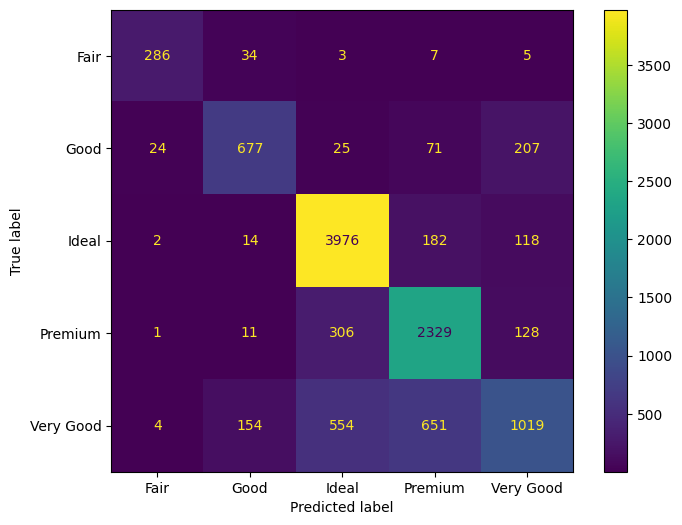

Best parameters from CV: {'est__max_depth': 20}


In [11]:
importlib.reload(aux)
path = Path('diamonds.csv')
features = ['carat', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']

param_grid = {'est__max_depth': [5, 10, 20, 40],
             }

model = aux.run_model(path, features, 
    RandomForestClassifier(n_estimators=50, random_state=42), param_grid);

print(f'Best parameters from CV: {model.best_params_}')